# **DeepFashion2 Dataset**

This notebook contains preprocessing of the data to feed to the model

**Summary**

*   Downloaded DeepFashion2 dataset, images and annotations
*   Annotations converted to coco format
*   Excluded images with high occlusion 
*   Generated mask corresponding to selected images
*   Generated Pytorch Dataset 




To get the data to Colab environment do the shortcut thing
https://drive.google.com/drive/folders/125F48fsMBz2EF0Cpqk6aaHet5VH399Ok?usp=sharing


Not done yet:
* Resizing
* Add channels to masks

* Data Augementation (if any)

**Data Summary**

  | Train set | Validation set| Test set |
  |---|---|---|
  |191961 | 32153 | 62629|

  Shape of images are not equal

  After excluding images with high occlusion we get:

  | Train set | Validation set| Test set |
  |---|---|---|
  |64648 | 10221 | 62629|


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

from pycocotools.coco import COCO
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import cv2
import json

from torchvision import datasets, transforms, models
from torch.utils.data import Dataset

import os
import PIL
import scipy as sp
import random

from IPython import display
from tqdm import trange, tqdm

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where train/ test/ validation/ sets are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/DeepFashion2 Dataset")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Extract Zipped Images***

In [0]:
# unzip data
!unzip -P 2019Deepfashion2** -q "{AUX_DATA_ROOT / 'train.zip'}"
!unzip -P 2019Deepfashion2** -uq "{AUX_DATA_ROOT / 'validation.zip'}"
!unzip -P 2019Deepfashion2** -q "{AUX_DATA_ROOT / 'test.zip'}"
!unzip -P 2019Deepfashion2** -q "{AUX_DATA_ROOT / 'json_for_validation.zip'}"


# just in case (if unzip crushes)
# !sudo apt-get install p7zip-full
# !7z x "{AUX_DATA_ROOT / 'train.zip'}" -p2019Deepfashion2**
# !7z x "{AUX_DATA_ROOT / 'validation.zip'}" -p2019Deepfashion2**
# !7z x "{AUX_DATA_ROOT / 'test.zip'}" -p2019Deepfashion2**
# !7z x "{AUX_DATA_ROOT / 'json_for_validation.zip'}" -p2019Deepfashion2**

***Get Image Paths***

In [0]:
# Image and annotations paths
train_images_dir = 'train/image/'
train_annos_dir = 'train/annos/'
validation_images_dir = 'validation/image/'
validation_annos_dir = 'validation/annos/'
test_images_dir = 'test/image/'

***Convert to coco format***

This in order to get the most out of coco built in functions, such as *annToMask()*

In [0]:
import json
from PIL import Image
import numpy as np

dataset = {
    "info": {},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": []
}

dataset['categories'].append({
    'id': 1,
    'name': "short_sleeved_shirt",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 2,
    'name': "long_sleeved_shirt",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 3,
    'name': "short_sleeved_outwear",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 4,
    'name': "long_sleeved_outwear",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 5,
    'name': "vest",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 6,
    'name': "sling",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 7,
    'name': "shorts",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 8,
    'name': "trousers",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 9,
    'name': "skirt",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 10,
    'name': "short_sleeved_dress",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 11,
    'name': "long_sleeved_dress",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 12,
    'name': "vest_dress",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})
dataset['categories'].append({
    'id': 13,
    'name': "sling_dress",
    'supercategory': "clothes",
    'keypoints': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294'],
    'skeleton': []
})

def getCocoAnns(annos_dir, images_dir, coco_anns_name):
    num_images = len(os.listdir(images_dir))
    sub_index = 0 # the index of ground truth instance
    for num in range(1, num_images+1):
        json_name = annos_dir + str(num).zfill(6)+'.json'
        image_name = images_dir + str(num).zfill(6)+'.jpg'

        if (num>=0):
            # imag = Image.open(image_name)
            # width, height = imag.size
            with open(json_name, 'r') as f:
                temp = json.loads(f.read())
                pair_id = temp['pair_id']

                skip = False # Skip images with high occlusion
                for it in temp:
                    if it == 'source' or it=='pair_id':
                        continue
                    else:
                        if temp[it]['occlusion'] != 1:
                            skip = True

                if skip == False:
                    #if num % 1000 == 0: print('processing item:', num)

                    imag = Image.open(image_name)
                    width, height = imag.size

                    dataset['images'].append({
                        'coco_url': '',
                        'date_captured': '',
                        'file_name': str(num).zfill(6) + '.jpg',
                        'flickr_url': '',
                        'id': num,
                        'license': 0,
                        'width': width,
                        'height': height
                    })
                    for i in temp:
                        if i == 'source' or i=='pair_id':
                            continue
                        else:
                            points = np.zeros(294 * 3)
                            sub_index = sub_index + 1
                            box = temp[i]['bounding_box']
                            w = box[2]-box[0]
                            h = box[3]-box[1]
                            x_1 = box[0]
                            y_1 = box[1]
                            bbox=[x_1,y_1,w,h]
                            cat = temp[i]['category_id']
                            style = temp[i]['style']
                            seg = temp[i]['segmentation']
                            landmarks = temp[i]['landmarks']

                            points_x = landmarks[0::3]
                            points_y = landmarks[1::3]
                            points_v = landmarks[2::3]
                            points_x = np.array(points_x)
                            points_y = np.array(points_y)
                            points_v = np.array(points_v)

                            if cat == 1:
                                for n in range(0, 25):
                                    points[3 * n] = points_x[n]
                                    points[3 * n + 1] = points_y[n]
                                    points[3 * n + 2] = points_v[n]
                            elif cat ==2:
                                for n in range(25, 58):
                                    points[3 * n] = points_x[n - 25]
                                    points[3 * n + 1] = points_y[n - 25]
                                    points[3 * n + 2] = points_v[n - 25]
                            elif cat ==3:
                                for n in range(58, 89):
                                    points[3 * n] = points_x[n - 58]
                                    points[3 * n + 1] = points_y[n - 58]
                                    points[3 * n + 2] = points_v[n - 58]
                            elif cat == 4:
                                for n in range(89, 128):
                                    points[3 * n] = points_x[n - 89]
                                    points[3 * n + 1] = points_y[n - 89]
                                    points[3 * n + 2] = points_v[n - 89]
                            elif cat == 5:
                                for n in range(128, 143):
                                    points[3 * n] = points_x[n - 128]
                                    points[3 * n + 1] = points_y[n - 128]
                                    points[3 * n + 2] = points_v[n - 128]
                            elif cat == 6:
                                for n in range(143, 158):
                                    points[3 * n] = points_x[n - 143]
                                    points[3 * n + 1] = points_y[n - 143]
                                    points[3 * n + 2] = points_v[n - 143]
                            elif cat == 7:
                                for n in range(158, 168):
                                    points[3 * n] = points_x[n - 158]
                                    points[3 * n + 1] = points_y[n - 158]
                                    points[3 * n + 2] = points_v[n - 158]
                            elif cat == 8:
                                for n in range(168, 182):
                                    points[3 * n] = points_x[n - 168]
                                    points[3 * n + 1] = points_y[n - 168]
                                    points[3 * n + 2] = points_v[n - 168]
                            elif cat == 9:
                                for n in range(182, 190):
                                    points[3 * n] = points_x[n - 182]
                                    points[3 * n + 1] = points_y[n - 182]
                                    points[3 * n + 2] = points_v[n - 182]
                            elif cat == 10:
                                for n in range(190, 219):
                                    points[3 * n] = points_x[n - 190]
                                    points[3 * n + 1] = points_y[n - 190]
                                    points[3 * n + 2] = points_v[n - 190]
                            elif cat == 11:
                                for n in range(219, 256):
                                    points[3 * n] = points_x[n - 219]
                                    points[3 * n + 1] = points_y[n - 219]
                                    points[3 * n + 2] = points_v[n - 219]
                            elif cat == 12:
                                for n in range(256, 275):
                                    points[3 * n] = points_x[n - 256]
                                    points[3 * n + 1] = points_y[n - 256]
                                    points[3 * n + 2] = points_v[n - 256]
                            elif cat == 13:
                                for n in range(275, 294):
                                    points[3 * n] = points_x[n - 275]
                                    points[3 * n + 1] = points_y[n - 275]
                                    points[3 * n + 2] = points_v[n - 275]
                            num_points = len(np.where(points_v > 0)[0])

                            dataset['annotations'].append({
                                'area': w*h,
                                'bbox': bbox,
                                'category_id': cat,
                                'id': sub_index,
                                'pair_id': pair_id,
                                'image_id': num,
                                'iscrowd': 0,
                                'style': style,
                                'num_keypoints':num_points,
                                'keypoints':points.tolist(),
                                'segmentation': seg,
                            })


    json_name = coco_anns_name + '.json'
    with open(json_name, 'w') as f:
        json.dump(dataset, f)

In [0]:
# Generate coco annotation instances
getCocoAnns(train_annos_dir, train_images_dir, 'cocoInstances_train')
getCocoAnns(validation_annos_dir, validation_images_dir, 'cocoInstances_validation')

***Pytorch Dataset***

In [0]:
class DeepFasion2Dataset(Dataset):
    def __init__(self, data_dir, anns_dir, data_transform=None, mask_transform=None):
        super(DeepFasion2Dataset, self).__init__()

        self.annFile = anns_dir
        self.coco=COCO(self.annFile)
        imgIds = self.coco.getImgIds()
        self.images = self.coco.loadImgs(imgIds)

        self.data_dir = data_dir
        self.labels_dir = anns_dir

        # Transformations to apply
        self.data_transform = data_transform
        self.mask_transform = mask_transform

        
    def __getitem__(self, index):
        image= cv2.imread(os.path.join(self.data_dir, self.images[index]['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        annIds = self.coco.getAnnIds(imgIds=self.images[index]['id'], iscrowd=None)
        anns = self.coco.loadAnns(annIds)

        # Generating the masks
        mask = self.coco.annToMask(anns[0])
        for i in range(len(anns)):
            mask += self.coco.annToMask(anns[i])

        # Change position for pytorch from [h, w, c] >> [c, h, w]
        # and normalization applied
        image = image.transpose(2,0,1) 
        image = image.astype(np.float32)/255.

        return image, mask

    def __len__(self):
        return len(self.images)

***Testing***

In [0]:
# Load instances
train_coco_annos = 'cocoInstances_train.json'
validation_coco_annos = 'cocoInstances_validation.json'

In [44]:
train_dataset = DeepFasion2Dataset(train_images_dir,  train_coco_annos)
val_dataset = DeepFasion2Dataset(validation_images_dir, validation_coco_annos)


loading annotations into memory...
Done (t=2.44s)
creating index...
index created!


***Visualization of Dataset***

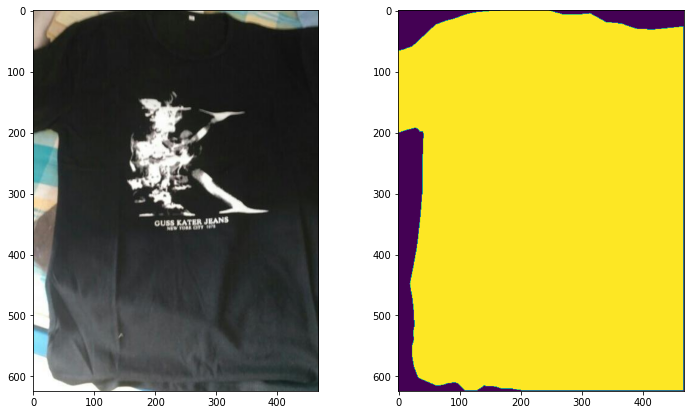

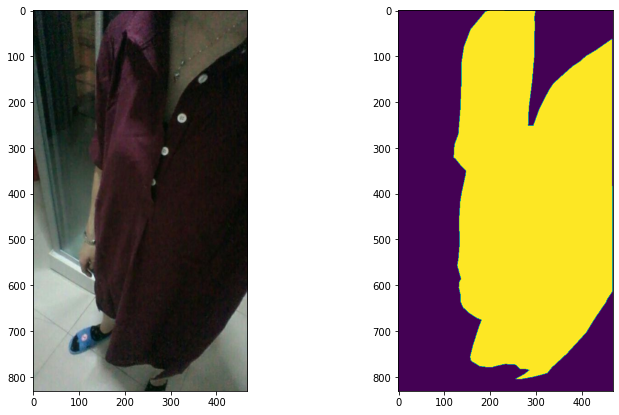

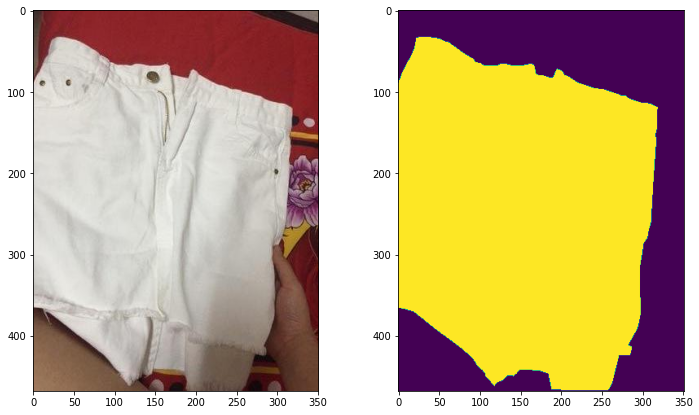

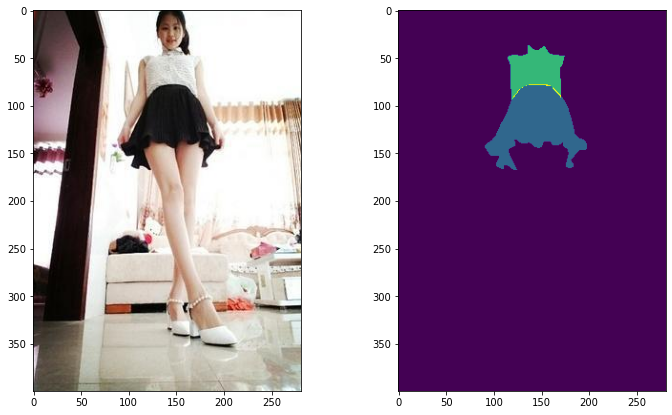

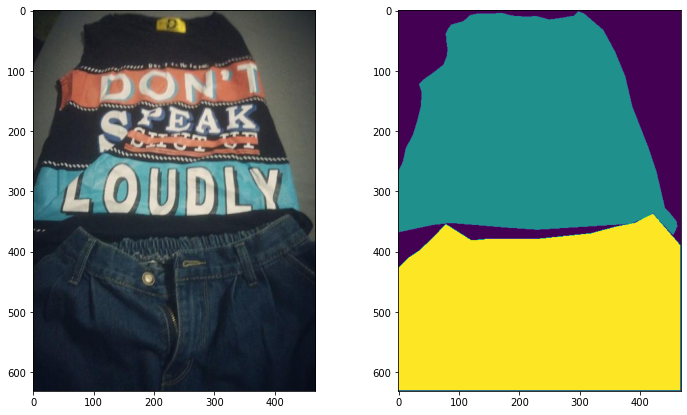

In [55]:
indices = np.random.randint(0, 100, 5)
for idx in indices:
    image, mask = val_dataset[idx]
    fig=plt.figure(figsize=(12, 7))
    fig.add_subplot(1, 2, 1)
    plt.imshow(image.transpose(1,2,0))
    fig.add_subplot(1, 2, 2)
    plt.imshow(mask)
    plt.show()